In [ ]:
import numpy as np
from keras import layers, Model
from keras.applications import InceptionV3
from keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import load_img, img_to_array
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model

## Load InceptionV3 Model

In [ ]:
pre_trained_model = InceptionV3(input_shape=(128, 128, 3),
                                include_top=False,
                                weights='imagenet')

In [ ]:
# Đóng băng các layer ngăn không cho train thay đổi params
for layer in pre_trained_model.layers:
    layer.trainable = False

In [ ]:
# Sử dụng layer 'mixed7' làm layer ouput cho network được thêm vào
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

## Transfer Learning

In [ ]:
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x) # Kỹ thuật tránh overfitting, 20% neurons ngẫu nhiên nhận giá trị 0
x = layers.Dense(10, activation='softmax')(x)

## Configure and Compile the model

In [ ]:
model = Model(pre_trained_model.input, x)
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.0001),
              metrics=['acc'])

## Data Preprocessing

In [ ]:
data_dir = 'data/train'

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

train_generator = datagen.flow_from_directory(data_dir,
                                              target_size=(128, 128),
                                              batch_size=32,
                                              class_mode='categorical',
                                              subset='training')
val_generator = datagen.flow_from_directory(data_dir,
                                            target_size=(128, 128),
                                            batch_size=32,
                                            class_mode='categorical',
                                            subset='validation')

Found 9630 images belonging to 10 classes.
Found 1060 images belonging to 10 classes.


## Train Model

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=15,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    verbose=2)
model.save('HWDRModel.h5')

Epoch 1/15
301/301 - 32s - loss: 0.5143 - acc: 0.8305 - val_loss: 0.2190 - val_acc: 0.9264 - 32s/epoch - 105ms/step
Epoch 2/15
301/301 - 13s - loss: 0.1694 - acc: 0.9444 - val_loss: 0.1781 - val_acc: 0.9340 - 13s/epoch - 44ms/step
Epoch 3/15
301/301 - 13s - loss: 0.0986 - acc: 0.9672 - val_loss: 0.1704 - val_acc: 0.9472 - 13s/epoch - 45ms/step
Epoch 4/15
301/301 - 14s - loss: 0.0662 - acc: 0.9783 - val_loss: 0.1686 - val_acc: 0.9462 - 14s/epoch - 45ms/step
Epoch 5/15
301/301 - 14s - loss: 0.0466 - acc: 0.9849 - val_loss: 0.1543 - val_acc: 0.9509 - 14s/epoch - 45ms/step
Epoch 6/15
301/301 - 13s - loss: 0.0314 - acc: 0.9899 - val_loss: 0.1388 - val_acc: 0.9547 - 13s/epoch - 44ms/step
Epoch 7/15
301/301 - 13s - loss: 0.0283 - acc: 0.9920 - val_loss: 0.1624 - val_acc: 0.9491 - 13s/epoch - 44ms/step
Epoch 8/15
301/301 - 13s - loss: 0.0194 - acc: 0.9943 - val_loss: 0.1306 - val_acc: 0.9594 - 13s/epoch - 44ms/step
Epoch 9/15
301/301 - 14s - loss: 0.0175 - acc: 0.9948 - val_loss: 0.1363 - val_

## Make Prediction

In [ ]:
def load_image(img_path):
    img = load_img(img_path, target_size=(128, 128), interpolation='nearest')
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
# Func giúp nhận dạng chữ số từ model đã train
def predict(img, model):
    pred = model.predict(img,verbose=None)
    digit = np.argmax(pred)
    return digit

In [ ]:
!pip install pillow_heif

In [ ]:
# Nhận dạng chữ số và lưu kết quả vào df
import os
import pandas as pd
from tqdm import tqdm
from PIL import Image
import pillow_heif

df = pd.DataFrame(columns=['', ''])
folder_path = 'data/test'
heic_count = 0 # số file có đuôi .HEIC
md_count = 0 # số file có đuôi .md
i = 0

model = load_model('HWDRModel.h5')

list_file = os.listdir(folder_path)

for filename in tqdm(list_file):
    file_path = os.path.join(folder_path, filename)
    # Bỏ qua file có đuôi .md
    if filename.endswith(".md"):
        heic_count += 1
        continue

    # Ảnh có đuôi .HEIC copy thành ảnh mới với đuôi .png
    elif filename.endswith(".HEIC"):
        heif_file = pillow_heif.read_heif(file_path)
        image = Image.frombytes(heif_file.mode,
                                heif_file.size,
                                heif_file.data,
                                "raw")
        new_filepath = file_path[:4]+'png'
        image.save(new_filepath, format="png")

        # Nhận dạng ảnh
        img = load_image(new_filepath)
        digit = predict(img, model)
        # Lưu vào df
        df.loc[i] = [filename, str(digit)]

        # Xoá ảnh vừa tạo ra
        os.remove(new_filepath)
        md_count += 1

    else:
        img = load_image(file_path)
        digit = predict(img, model)
        df.loc[i] = [filename, str(digit)]

    i += 1

print(f'HEIC count: {heic_count}, md count: {md_count}')

100%|██████████| 2939/2939 [06:12<00:00,  7.89it/s]

HEIC count: 11, md count: 30


In [ ]:
df.head()

,,
0,9f2f7c68789fa7fde6752ccef2c25354 -.jpg,1
1,dac6f225188b8a22ac3dfd3dd3dc58d1 -.jpg,1
2,661cd0c6627ddfc236ea60baf71c1b91 -.jpg,5
3,11456fa3a8a9879a7e5efe63c073d010 -.jpg,7
4,f0dc2d42dbf1be295bc8fb0769a35f1b -.png,7


In [ ]:
df.to_csv('final.csv', index=False, header=False) # Xuất file

In [ ]:
import pandas as pd
df = pd.read_csv('final.csv', names=['FullPath', 'Digit'])
df

,FullPath,Digit
0,9f2f7c68789fa7fde6752ccef2c25354 -.jpg,1
1,dac6f225188b8a22ac3dfd3dd3dc58d1 -.jpg,1
2,661cd0c6627ddfc236ea60baf71c1b91 -.jpg,5
3,11456fa3a8a9879a7e5efe63c073d010 -.jpg,7
4,f0dc2d42dbf1be295bc8fb0769a35f1b -.png,7
...,...,...
2923,ef0f81d77fcda1ab019da920a961b8f0 -.jpg,2
2924,665e9d17678bf057916e0ae60bcacb50 -.jpg,0
2925,3b22081fd8a451ba2b758346814fb0b9 -.jpg,4
2926,700fbd91627c65875e7e4b62b7cca588 -.png,8


In [ ]:
list_img_show = []

In [ ]:
for i in range(10):
  paths = (df[(df['Digit'] == i) & (df['FullPath'].str.endswith('jpg'))]['FullPath'].iloc[:10]).to_list()
  full_paths = ['data/test/' + path for path in paths]
  list_img_show.append(full_paths)

In [ ]:
list_img_show[:1]

[['data/test/2a7c02861383d4148daef07cdf285013  -.jpg',
  'data/test/65652439743cad30866c3c7414feb1e5  -.jpg',
  'data/test/7ccb13bec239533571a628d48ae4017d  -.jpg',
  'data/test/5d4cf8e80ca27544ade94a1b8eec594c  -.jpg',
  'data/test/f62af0ea38fcc952e0a12aa504476a0b  -.jpg',
  'data/test/d109fe7187a0d1c5f9ea0c0707450cdd  -.jpg',
  'data/test/7e9304df23fc7a43e918d7085dccc533  -.jpg',
  'data/test/385846d32a2853af0276b3a32f9e0806  -.jpg',
  'data/test/b90cd8bf1e23c6edd4f1d401fcf12b03  -.jpg',
  'data/test/b96dcef90ba1627f6ee7cefedc36526f  -.jpg']]

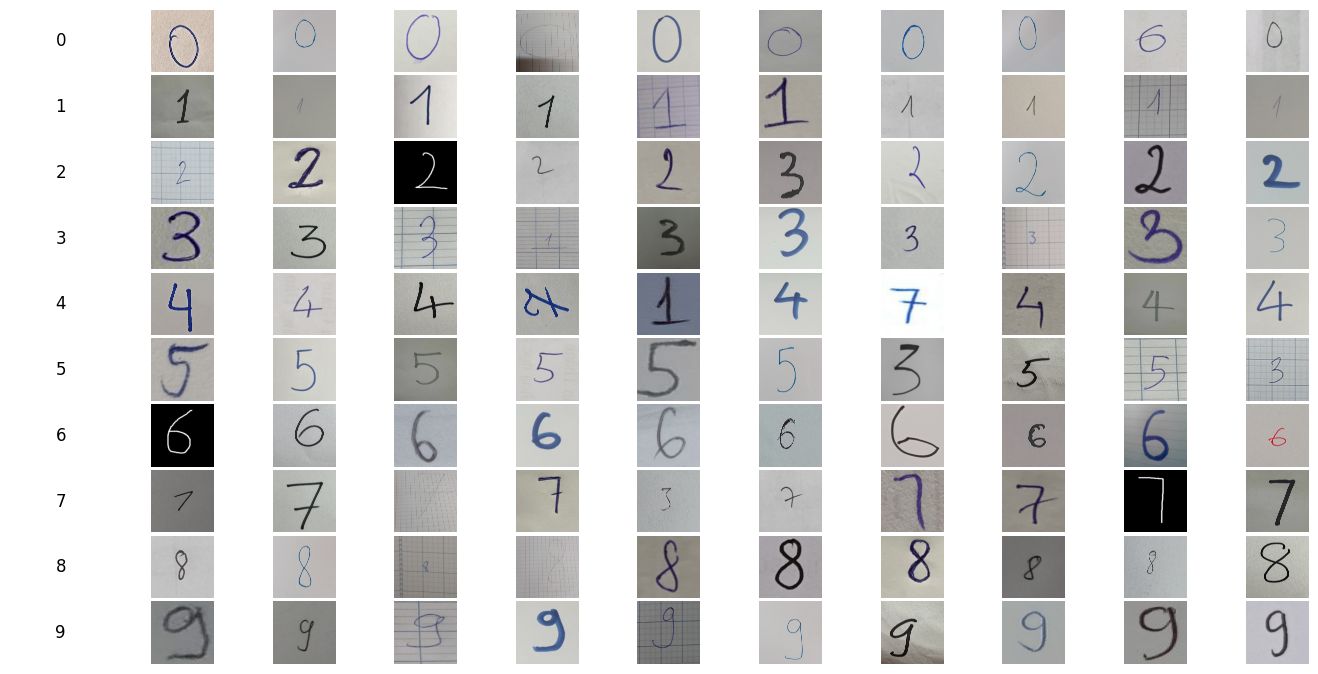

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Show một vài ảnh đã được model nhận dạng
# Khởi tạo fig và axs để hiển thị ảnh
fig, axs = plt.subplots(10, 10 + 1, figsize=(17, 0.5*17))
fig.subplots_adjust(hspace=0.05)

# Duyệt qua từng hàng
for i in range(10):
  # Set vị trí sau đó hiển thị số
  ax = axs[(i, 0)]
  ax.text(0.5, 0.5, str(i), ha='center', va='center', fontsize=12)
  ax.axis('Off') # Tắt axes (hoặc gridlines)
  # Duyệt qua từng cột
  for j in range(10):

    # Set vị trí sau đó hiển thị ảnh
    ax = axs[(i, j + 1)]
    img = mpimg.imread(list_img_show[i][j])
    ax.imshow(img, extent=[0, 17, 0, 17])

    ax.axis('Off')